# Full Flow
0. EDA
1. 파생변수 생성
2. 데이터 전처리
   - 특수문자 및 기호 등 필요없는 문자 제거
   - 대소문자 모두 소문자로 통일
   - 이름 | 불용어(분석에 필요없는 토큰) 제거 => TF-IDF 적용시 해결 가능, 이름 제거하는게 낫나 아니면 살리는게 낫나
   - 어근 추츨을 통한 텍스트 정규화 작업
   ----------------------------------
   - TF-IDF
   ---------------------------------
   - 벡터화 함수 적용
   ---------------------------------
   - 타켓 변수 불균형 해결
3. 모델 적합     
  **CatBoost**
4. 하이퍼파라미터튜닝
  - optuna
5. 모델 앙상블

# CatBoost
Catboost는 이름에서도 유추 가능하듯이 Cat, Category 즉 범주형 변수가 많은 데이터를 학습할 때 성능이 좋음

https://julie-tech.tistory.com/119

# 라이브러리 및 데이터 불러오기

In [ ]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# Catboost 모델링
from catboost import CatBoostClassifier, Pool

In [ ]:
import nltk # 문장 토크나이저
nltk.download('all')

from nltk.corpus import names #corpus=말뭉치,이름 관련 부분 다루기 위한 객체

from nltk.corpus import stopwords # 영어 불용어 - 불용어 모아 놓은 리스트 다운로드해 제거

from nltk.tokenize import word_tokenize # 토큰화
from nltk.stem.porter import PorterStemmer # 어근 동일화 <-> 이거 말고도 "Lancaster Stemmer"

# 표제어 추출
from nltk.stem import WordNetLemmatizer

# 정규표현 처리
import re

In [4]:
# 구글 드라이브에서 데이터 불러오기
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import zipfile

# ZIP 파일 열기
with zipfile.ZipFile('/content/gdrive/MyDrive/0000/dacon_lawwinner/open.zip', 'r') as zip_ref:
    # 파일 목록 가져오기
    file_list = zip_ref.namelist()

    # 파일 목록 출력
    for file in file_list:
        print(file)

    # 모든 파일 압축 해제
    zip_ref.extractall()

sample_submission.csv
test.csv
train.csv


In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sample_submission.csv")

# 파생변수 생성

### sentence / word Len

##### train

In [ ]:
train['sen_len'] = 0 # 문장 토큰화
train['word_len'] = 0 # 단어 토큰화

for i in range(len(train)):
  train.sen_len[i] = len(nltk.sent_tokenize(train.facts[i]))
  train.word_len[i] = len(word_tokenize(train.facts[i]))

train = train[['ID', 'first_party', 'second_party', 'facts', 'sen_len', 'word_len', 'first_party_winner']]
train.head(10)

##### test

In [ ]:
test['sen_len'] = 0 # 문장 토큰화
test['word_len'] = 0 # 단어 토큰화

for i in range(len(test)):
  test.sen_len[i] = len(nltk.sent_tokenize(test.facts[i]))
  test.word_len[i] = len(word_tokenize(test.facts[i]))

test = test[['ID', 'first_party', 'second_party', 'facts', 'sen_len', 'word_len']]
test.head(10)

### issued_area

#### keybert
원본 문서를 가장 잘 나타내는 중요한 용어 또는 구문을 찾아내는 작업
- Bert를 이용해 문서레벨에서의 주제를 파악
- N-gram을 위해 단어 임베딩
- 코사인 유사도 계산해 어떤 N-gram 단어 또는 구가 문서와 가장 유사한지 확인    


**MMR**   
검색 엔진 내에서 본문 검색 관련해 검색에 따른 결과의 다양성과 연관성을 조절하는 방법
- 문서와 가장 유사한 키워드 선택
- 문서와 비슷하면서도 이미 선택한 키워드와 비슷하지 않은 새 후보 반복적으로 선택


In [ ]:
!pip install keybert

In [10]:
from keybert import KeyBERT

In [ ]:
# 중요 어구 추출
'''kw_model = KeyBERT()
keywords = kw_model.extract_keywords(train['facts'],
                                                keyphrase_ngram_range=(2,4),
                                                use_maxsum = True,
                                                top_n = 10)'''

In [ ]:
# 중요 단어 추출
train['fact_processing'] = train['facts'].apply(cleaning)
array_text = train['fact_processing'].to_numpy()

bow_cleaned = []

kw_extractor = KeyBERT('distilbert-base-nli-mean-tokens')
for j in range(len(array_text)):
    keywords1 = kw_extractor.extract_keywords(array_text[j])
    bow_cleaned.append(keywords1)

In [15]:
keywords_list = [[item[0] for item in sublist] for sublist in bow_cleaned]
keywords_list

[['sheriff', 'louisiana', 'june', 'communist', 'baton'],
 ['murder', 'death', 'convict', 'prison', 'drug'],
 ['murder', 'prison', 'convict', 'death', 'alabama'],
 ['retrial', 'convict', 'trial', 'suprem', 'fourth'],
 ['april', 'daughter', 'selma', 'death', 'alabama'],
 ['clarkstown', 'indiana', 'contractor', 'landfil', 'suprem'],
 ['detain', 'detaine', 'demonstr', 'provid', 'statutori'],
 ['demonstr', 'mailroom', 'discrimin', 'lost', 'prohibit'],
 ['murder', 'robberi', 'convict', 'antiterror', 'death'],
 ['baptist', 'tennesse', 'declaratori', 'suprem', 'church'],
 ['beer', 'brewer', 'distributor', 'provid', 'indiana'],
 ['voter', 'mississippi', 'vote', 'virginia', 'elect'],
 ['california', 'tax', 'organ', 'refund', 'church'],
 ['michigan', 'ohio', 'provid', 'kentucki', 'tennesse'],
 ['lawsuit', 'financi', 'plaintiff', 'fiduciari', 'monetari'],
 ['automobil', 'traffic', 'provid', 'liabil', 'evalu'],
 ['alien', 'texa', 'unnam', 'school', 'law'],
 ['retrial', 'convict', 'conspiraci', 'cer

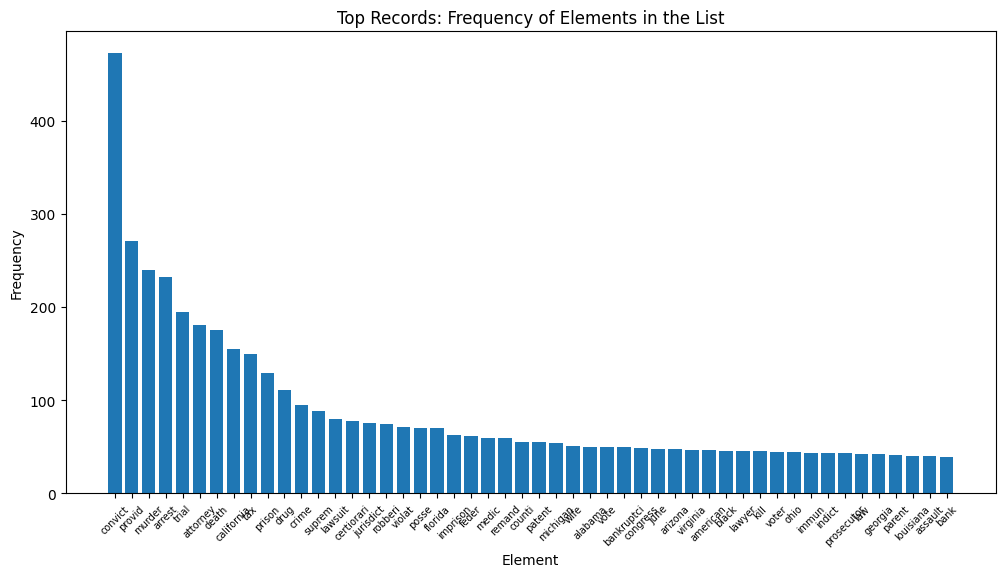

In [16]:
import matplotlib.pyplot as plt

# 통합 keywords 리스트 생성
lst = keywords_list[0]
for i in range(2477):
  lst = lst + keywords_list[i+1]

# 원소별 빈도 계산
counts = {}
for item in lst:
    counts[item] = counts.get(item, 0) + 1

# 빈도를 기준으로 내림차순으로 정렬하여 상위 레코드 선택
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
top_records = sorted_counts[:50]  # 상위 5개 레코드만 선택

# 그래프 크기 조정
plt.figure(figsize=(12, 6))

# 막대 그래프 생성
labels = [record[0] for record in top_records]
values = [record[1] for record in top_records]
plt.bar(labels, values)
plt.xlabel('Element')
plt.ylabel('Frequency')
plt.title('Top Records: Frequency of Elements in the List')
# x축 눈금 레이블의 속성 변경
plt.xticks(fontsize=7,rotation=45)

plt.show()

In [17]:
train['keywords_list'] = keywords_list

#### 판결 유형 대분류표 생성




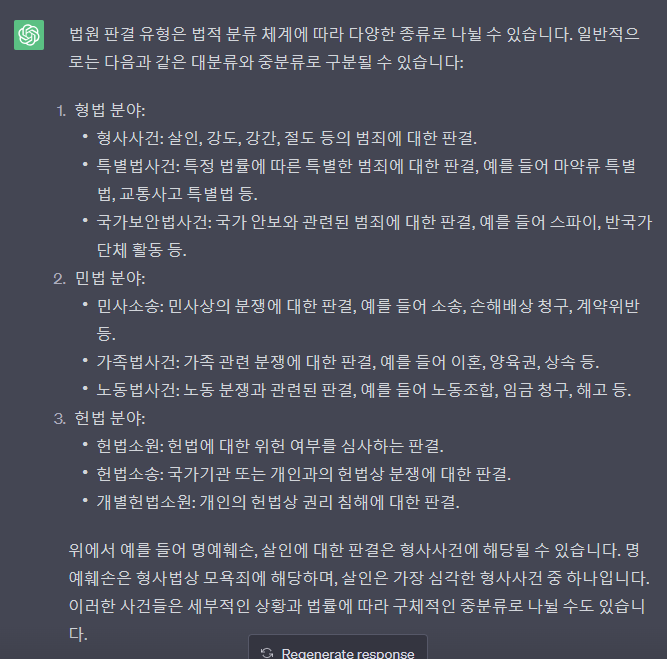

In [18]:
## 형사
criminal = ['murder', 'robbery', 'rape', 'theft','larceny', 'criminal','assault',
'drug', 'traffic', 'spy', 'espionage', 'marijuana', 'rape', 'burglarious']

## 민사
civil = ['lawsuits', 'contract violations',
'divorce', 'child custody', 'inheritance',
'labor unions' , 'wage claims', 'terminations',
'defamation','Slander', 'libel', 'reputation','bankruptcy', 'fraud','kidnap'
]

## 헌법
constitutional = ['Constitutional Petitions',
'constitutional disputes',
'individual constitutional rights']

df = pd.DataFrame({
    'main_words':criminal + civil + constitutional,
    'category' : len(criminal)*["criminal"]+len(civil)*["civil"]+len(constitutional)*["constitutional"]
})

df['main_procssing']= df['main_words'].apply(cleaning)
df

,main_words,category,main_procssing
0,murder,criminal,murder
1,robbery,criminal,robberi
2,rape,criminal,rape
3,theft,criminal,theft
4,larceny,criminal,larceni
5,criminal,criminal,crimin
6,assault,criminal,assault
7,drug,criminal,drug
8,traffic,criminal,traffic
9,spy,criminal,spi


#### train : 최종 category 변수 생성

In [24]:
def finding_cateory(lst):
    k = 0
    for item in lst:
      if item in df.main_procssing.values:
        k = df.loc[df['main_procssing'] == item, 'category'].values[0]
      # 값이 저장되었다면 for 구문 중단
      if k != 0:
        break
    # k 값이 없다면 기타
    if k == 0:
      k = 'others'
    return k

In [25]:
train['category'] = 0

for i in range(len(train)):
  train['category'][i] = finding_cateory(keywords_list[i])

In [26]:
train = train[['ID', 'first_party', 'second_party', 'facts','category', 'sen_len', 'word_len', 'first_party_winner'  ]]
train = train.rename(columns={'category':'issued_area'})
train

,ID,first_party,second_party,facts,issued_area,sen_len,word_len,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",others,7,201,1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,criminal,7,219,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,criminal,8,191,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,others,3,59,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",others,9,200,1
...,...,...,...,...,...,...,...,...
2473,TRAIN_2473,"HollyFrontier Cheyenne Refining, LLC, et al.","Renewable Fuels Association, et al.",Congress amended the Clean Air Act through the...,others,5,144,1
2474,TRAIN_2474,"Grupo Mexicano de Desarrollo, S. A.","Alliance Bond Fund, Inc.","Alliance Bond Fund, Inc., an investment fund, ...",others,7,184,1
2475,TRAIN_2475,Peguero,United States,"In 1992, the District Court sentenced Manuel D...",criminal,6,195,0
2476,TRAIN_2476,Immigration and Naturalization Service,St. Cyr,"On March 8, 1996, Enrico St. Cyr, a lawful per...",others,8,194,0


#### test

In [27]:
test['category'] = 0

for i in range(len(test)):
  test['category'][i] = finding_cateory(keywords_list[i])

In [28]:
test = test[['ID', 'first_party', 'second_party', 'facts','category', 'sen_len', 'word_len']]
test = test.rename(columns={'category':'issued_area'})
test

,ID,first_party,second_party,facts,issued_area,sen_len,word_len
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...,others,2,55
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...,criminal,7,209
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa...",criminal,7,181
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...,others,6,99
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a...",others,6,154
...,...,...,...,...,...,...,...
1235,TEST_1235,"Haitian Centers Council, Inc., et al.","Chris Sale, Acting Commissioner, Immigration A...",According to Executive Order No. 12807 signed ...,criminal,5,156
1236,TEST_1236,Whitman,"American Trucking Associations, Inc.",Section 109(a) of the Clean Air Act (CAA) requ...,criminal,7,221
1237,TEST_1237,Linda A. Matteo and John J. Madigan,William G. Barr,Linda Matteo and John Madigan created a plan f...,others,12,236
1238,TEST_1238,Washington State Apple Advertising Commission,Hunt,"In 1972, the North Carolina Board of Agricultu...",others,3,84


### winning_percent
**first_party_win_percent**
  첫 번째 당사자가 승소할 확률.
- 출현 빈도가 2이상일때만 반영함. 1일때는 0.5
- test에서는 first_party가 train의 first_party와 겹치는 경우에는 해당 사람의 승소할 확률을 반영함. 겹치지 않는 경우는 0.5로 반영함.

##### train

In [29]:
# winner: 해당 사건에서 승소한 사람
# win_percentage: 승소한 사람이 다른 사건에서도 승소할 확률

train['winner']=0
for i in range(2478):
  if train['first_party_winner'][i]==1:
    train['winner'][i] = train['first_party'][i]
  else:
    train['winner'][i] = train['second_party'][i]

train['win_percentage']=0
for i in range(2478):
  winner_exp = len(train.loc[train['first_party'] == train['winner'][i]])
  loose_exp = len(train.loc[train['second_party'] == train['winner'][i]])
  train['win_percentage'][i]= len(train.loc[train['winner'] == train['winner'][i]]) /(winner_exp + loose_exp)

In [30]:
# first_party_frequency: first_party가 나타난 빈도
# first_party_win_percent: first_party가 승소할 확률
train['first_party_win_percent'] = 0
train['first_party_frequency'] = 0

for i in range(2478):
  train['first_party_frequency'][i] = len(train.loc[train['first_party'] == train['first_party'][i]]) + len(train.loc[train['second_party'] == train['first_party'][i]])

  # 출현 빈도가 2이상일때만 반영함. 1일때는 0.5
  if train['first_party_frequency'][i] > 1:
    p = len(train.loc[train['winner'] == train['first_party'][i]]) / train['first_party_frequency'][i]
    train['first_party_win_percent'][i] = p
  else:
    train['first_party_win_percent'][i] = 0.5

In [31]:
train = train.drop(['winner',	'win_percentage','first_party_frequency'],axis=1)
train.tail(30)

,ID,first_party,second_party,facts,issued_area,sen_len,word_len,first_party_winner,first_party_win_percent
2448,TRAIN_2448,Pennsylvania,Delaware Valley Citizens' Council for Clean Air,"In April of 1973, pursuant to the Clean Air Ac...",others,13,394,1,0.62500
2449,TRAIN_2449,WesternGeco LLC,ION Geophysical Corporation,The US Supreme Court issued a 2016 order grant...,others,9,254,1,0.50000
2450,TRAIN_2450,Helling,McKinney,"William McKinney, a Nevada state prisoner, sue...",others,4,163,0,0.50000
2451,TRAIN_2451,"Hana Financial, Inc.","Hana Bank, et al.","In the spring of 1994, Hana Bank, a Korean ent...",others,10,304,0,0.50000
2452,TRAIN_2452,Police Department of the City of Chicago,Mosley,Chicago adopted an ordinance prohibiting picke...,others,3,54,0,0.50000
2453,TRAIN_2453,City of Oklahoma City,"Rose Marie Tuttle, Individually and as Adminis...","On October 10, 1980, an Oklahoma City police o...",others,5,180,1,0.50000
2454,TRAIN_2454,Rotella,Wood,Mark Rotella was admitted to a Brookhaven Psyc...,others,8,254,0,0.50000
2455,TRAIN_2455,Gregory Houston Holt,"Ray Hobbs, Director, Arkansas Department of Co...",Gregory Holt (also known as Abdul Maalik Muham...,others,6,190,1,0.50000
2456,TRAIN_2456,United States,Lanier,David W. Lanier was convicted under 18 U.S.C. ...,criminal,7,223,1,0.57868
2457,TRAIN_2457,Crosby,National Foreign Trade Council,"In 1996, the Massachusetts Burma Law, which re...",others,7,189,0,0.50000


##### test

In [32]:
# train 기준 컬럼 생성
train_first_party = train[['first_party','first_party_win_percent']]
train_first_party = train_first_party.drop_duplicates()
train_first_party.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2470    False
2473    False
2474    False
2475    False
2477    False
Length: 2110, dtype: bool

In [33]:
# 병합
test_percent = pd.merge(test.first_party, train_first_party, how='left')
test_percent = test_percent.fillna(0.5)

# test에 새로운 컬럼 추가
test['first_party_win_percent'] = test_percent['first_party_win_percent']

### party 분류
Defining Entity type for each party
- https://github.com/smitp415/CSCI_544_Final_Project

In [34]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [35]:
def data_distribution_graph(df, cols):
    for feature in cols:
        fig, ax = plt.subplots()
        percent = df.groupby(feature).size() / df[feature].count() * 100
        count = df.groupby(feature).size()

        if feature == 'facts_len':
          count = pd.cut(df['facts_len'], [1,50,500,1000,1500,3000,7000], include_lowest=True)
          percent = df.groupby(count).size() / df[feature].count() * 100
          count = df.groupby(count).size()
          ax = percent.plot(kind='barh', figsize=(10,10), xticks = range(0,101,5), fontsize=12)
        elif feature == 'term':
          ax = percent.plot(kind='barh', figsize=(10,20), xticks = range(0,101,5), fontsize=12)
        else:
          ax = percent.plot(kind='barh', figsize=(10,10), xticks = range(0,101,5), fontsize=12)

        # print count and percentage on grapp
        for i, v in enumerate(zip(percent.values, count.values)):
            percent = '{v}%'.format(v = round(v[0],2))
            ax.text(v[0] + 2, i - .25, percent, color='black', fontweight='bold', fontsize=12)
            ax.text(v[0] + 15, i - .25, str(v[1]), color='blue', fontweight='bold', fontsize=12)

        ax.set_title('Data Distribution - {feature}'.format(feature= feature), fontsize=20)
        ax.set_xlabel("Percentage", fontsize=20)
        ax.set_ylabel(feature, fontsize=20)

#### train

In [36]:
for idx, value in train.iterrows():
  first = value['first_party']
  second = value['second_party']
  doc = nlp(first)
  for ent in doc.ents:
    train.loc[idx, 'first_party_ner'] = ent.label_
  doc = nlp(second)
  for ent in doc.ents:
    train.loc[idx, 'second_party_ner'] = ent.label_

(None, None)

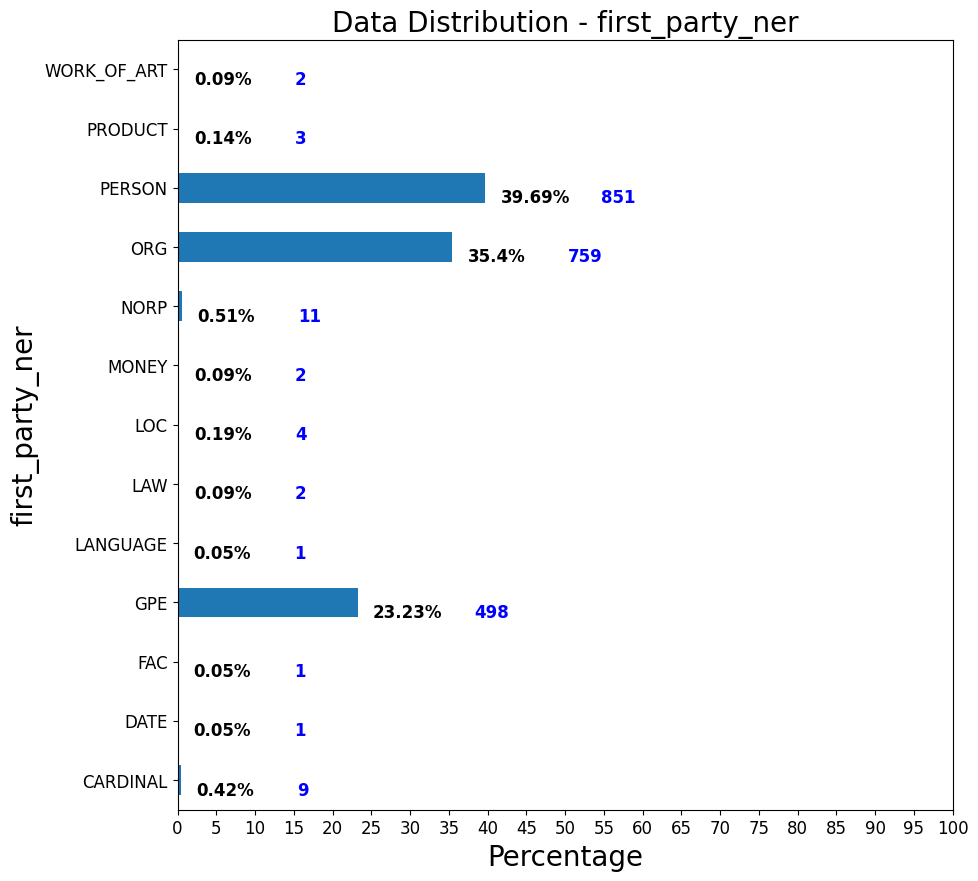

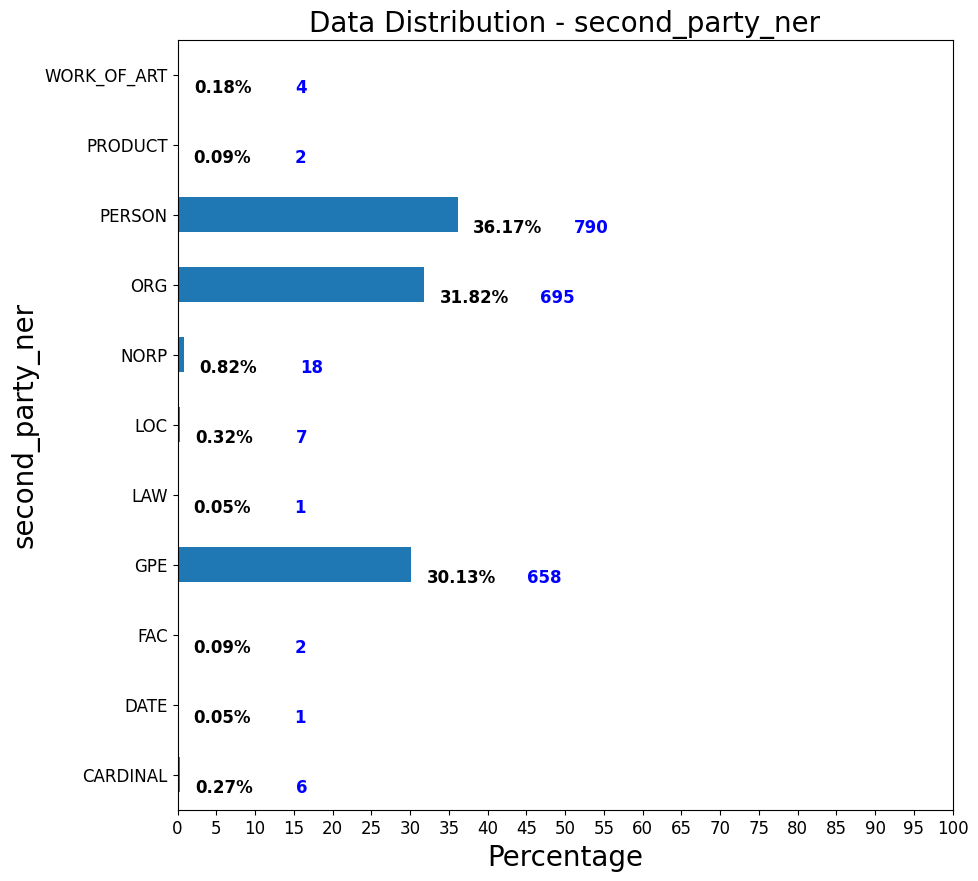

In [37]:
data_distribution_graph(train, ['first_party_ner']),data_distribution_graph(train, ['second_party_ner']),

#### test

In [38]:
for idx, value in test.iterrows():
  first = value['first_party']
  second = value['second_party']
  doc = nlp(first)
  for ent in doc.ents:
    test.loc[idx, 'first_party_ner'] = ent.label_
  doc = nlp(second)
  for ent in doc.ents:
    test.loc[idx, 'second_party_ner'] = ent.label_

(None, None)

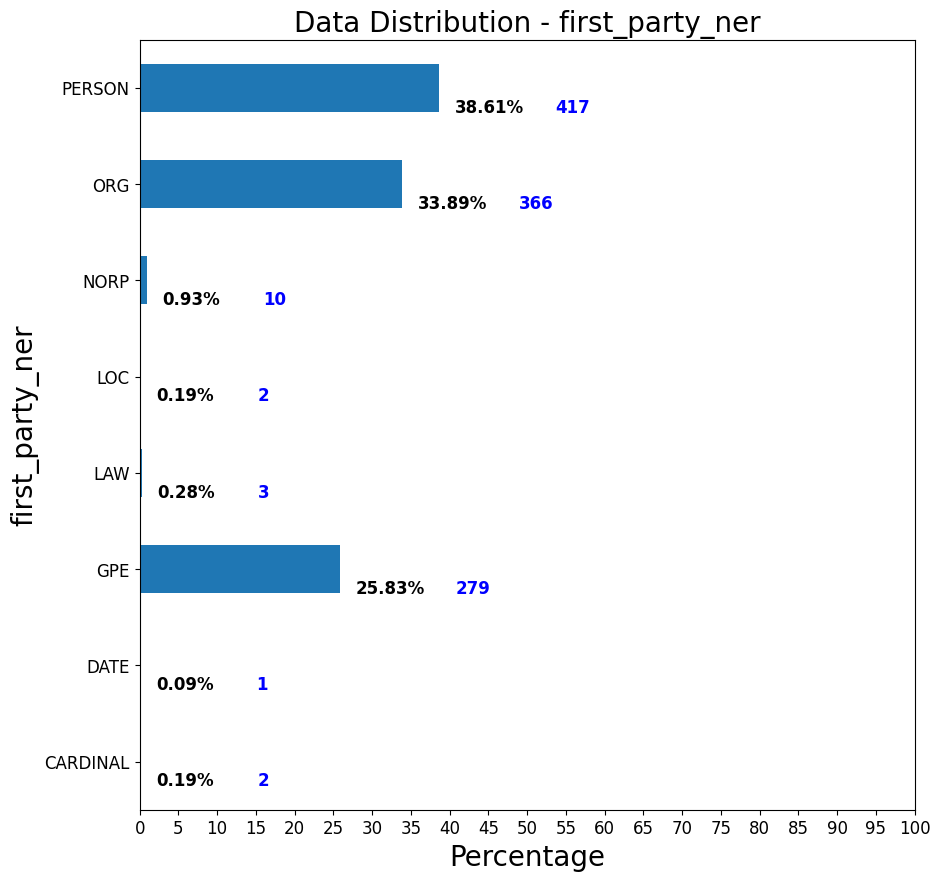

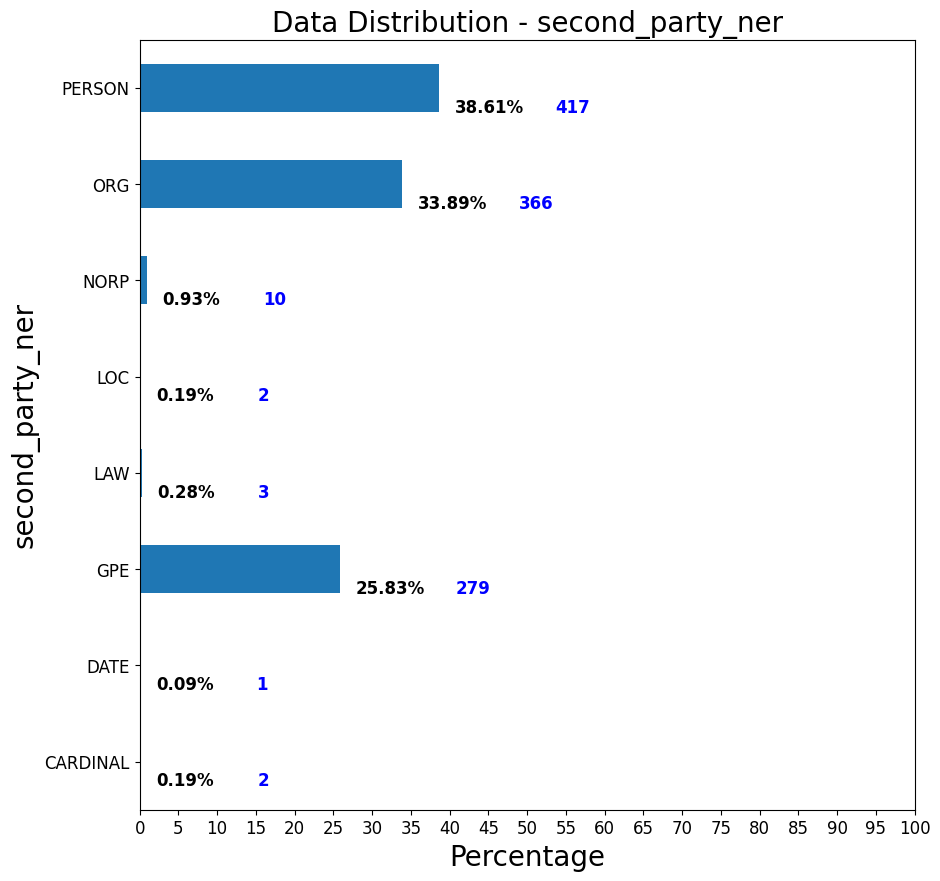

In [39]:
data_distribution_graph(test, ['first_party_ner']), data_distribution_graph(test, ['second_party_ner'])

#### 카테고리 통합

person / org / gpe / others ( 나머지 카테고리 포함 + 결측값 )

In [40]:
train.first_party_ner.value_counts(), train.second_party_ner.value_counts(),test.first_party_ner.value_counts(), test.second_party_ner.value_counts()

(PERSON         851
 ORG            759
 GPE            498
 NORP            11
 CARDINAL         9
 LOC              4
 PRODUCT          3
 LAW              2
 MONEY            2
 WORK_OF_ART      2
 LANGUAGE         1
 DATE             1
 FAC              1
 Name: first_party_ner, dtype: int64,
 PERSON         790
 ORG            695
 GPE            658
 NORP            18
 LOC              7
 CARDINAL         6
 WORK_OF_ART      4
 FAC              2
 PRODUCT          2
 DATE             1
 LAW              1
 Name: second_party_ner, dtype: int64,
 PERSON      417
 ORG         366
 GPE         279
 NORP         10
 LAW           3
 CARDINAL      2
 LOC           2
 DATE          1
 Name: first_party_ner, dtype: int64,
 PERSON      417
 ORG         366
 GPE         279
 NORP         10
 LAW           3
 LOC           2
 CARDINAL      2
 DATE          1
 Name: second_party_ner, dtype: int64)

In [41]:
train.isnull().sum()

ID                           0
first_party                  0
second_party                 0
facts                        0
issued_area                  0
sen_len                      0
word_len                     0
first_party_winner           0
first_party_win_percent      0
first_party_ner            334
second_party_ner           294
dtype: int64

통합 !

In [42]:
my_list = ['NORP', 'CARDINAL', 'LOC', 'PRODUCT', 'LAW', 'MONEY',
           'WORK_OF_ART', 'LANGUAGE', 'DATE', 'FAC']

# 다른 카테고리 모두 others로 통합
## train
train.loc[train['first_party_ner'].isin(my_list), 'first_party_ner'] = 'others'
train.loc[train['second_party_ner'].isin(my_list), 'second_party_ner'] = 'others'

## test
test.loc[test['first_party_ner'].isin(my_list), 'first_party_ner'] = 'others'
test.loc[test['second_party_ner'].isin(my_list), 'second_party_ner'] = 'others'

In [43]:
# 결측값을 'others'로 치환
train.fillna('others', inplace=True)
test.fillna('others', inplace=True)

In [44]:
train.isnull().sum()

ID                         0
first_party                0
second_party               0
facts                      0
issued_area                0
sen_len                    0
word_len                   0
first_party_winner         0
first_party_win_percent    0
first_party_ner            0
second_party_ner           0
dtype: int64

In [45]:
train.first_party_ner.value_counts(), train.second_party_ner.value_counts(),test.first_party_ner.value_counts(), test.second_party_ner.value_counts()

(PERSON    851
 ORG       759
 GPE       498
 others    370
 Name: first_party_ner, dtype: int64,
 PERSON    790
 ORG       695
 GPE       658
 others    335
 Name: second_party_ner, dtype: int64,
 PERSON    417
 ORG       366
 GPE       279
 others    178
 Name: first_party_ner, dtype: int64,
 PERSON    417
 ORG       366
 GPE       279
 others    178
 Name: second_party_ner, dtype: int64)

### party name 치환

In [46]:
# 이름 치환함수
def replace_name(name, text, replace_word):
    names = name.split('|')
    words = text.split()
    for word in words:
      for n in names:
        if n in word:
            text = text.replace(word, replace_word)

    return text

# 정규표현식으로 first_party 여러번 중복 연달아 나오는 거 한 번만 나오게 바꾸기
def remove_duplicates(text):
    modified_text1 = re.sub(r'(first_party\s*)+', 'first_party ', text)
    modified_text2 = re.sub(r'(second_party\s*)+', 'second_party ', modified_text1)
    return modified_text2

#### train

In [47]:
# 데이터 손실 방지를 위해 값 복사
train['first_party1'] = train['first_party']
train['second_party1'] = train['second_party']
train['facts1'] = train['facts']

# 이름 치환을 위한 base
train['first_party1'] = train['first_party1'].str.replace(" ", "|")
train['second_party1'] = train['second_party1'].str.replace(" ", "|")

In [48]:
# 함수 각각 적용
for i in range(len(train)):
  train['facts1'][i] = replace_name(train['first_party1'][i], train['facts1'][i], 'first_party')
  train['facts1'][i] = replace_name(train['second_party1'][i], train['facts1'][i], 'second_party')

  train['facts1'][i] = remove_duplicates(train['facts1'][i])

#### test

In [49]:
# 데이터 손실 방지를 위해 값 복사
test['first_party1'] = test['first_party']
test['second_party1'] = test['second_party']
test['facts1'] = test['facts']

# 이름 치환을 위한 base
test['first_party1'] = test['first_party1'].str.replace(" ", "|")
test['second_party1'] = test['second_party1'].str.replace(" ", "|")

In [50]:
# 함수 각각 적용
for i in range(len(test)):
  test['facts1'][i] = replace_name(test['first_party1'][i], test['facts1'][i], 'first_party')
  test['facts1'][i] = replace_name(test['second_party1'][i], test['facts1'][i], 'second_party')

  test['facts1'][i] = remove_duplicates(test['facts1'][i])

# df 확인

In [51]:
train_df = train[['ID',
                  'first_party_ner', 'second_party_ner',
                  'facts1',
                  'issued_area',
                 'sen_len', 'word_len',
                  'first_party_win_percent',
                  'first_party_winner']]
test_df = test[['ID',
                  'first_party_ner', 'second_party_ner',
                  'facts1',
                  'issued_area',
                 'sen_len', 'word_len',
                  'first_party_win_percent']]

train_df = train_df.rename(columns={"first_party_ner":"first_party",
                                    "second_party_ner":"second_party",
                                    'facts1':"fact",
                                    "first_party_win_percent":"winning_percent"
                                    })
test_df = test_df.rename(columns={"first_party_ner":"first_party",
                                    "second_party_ner":"second_party",
                                    'facts1':"fact",
                                    "first_party_win_percent":"winning_percent"
                                    })

In [52]:
train_df

,ID,first_party,second_party,fact,issued_area,sen_len,word_len,winning_percent,first_party_winner
0,TRAIN_0000,PERSON,PERSON,"On June 27, 1962, first_party a candidate for ...",others,7,201,0.5,1
1,TRAIN_0001,PERSON,PERSON,Ramon Nelson was riding his bike when he suffe...,criminal,7,219,0.5,0
2,TRAIN_0002,PERSON,GPE,An Alabama state court convicted first_party o...,criminal,8,191,0.5,1
3,TRAIN_0003,others,others,Victor first_party was convicted in state cour...,others,3,59,0.5,0
4,TRAIN_0004,PERSON,GPE,"On April 24, 1953 in Selma, second_party an in...",others,9,200,0.5,1
...,...,...,...,...,...,...,...,...,...
2473,TRAIN_2473,ORG,ORG,Congress amended the Clean Air Act through the...,others,5,144,0.5,1
2474,TRAIN_2474,PERSON,ORG,"second_party an investment fund, purchased app...",others,7,184,0.5,1
2475,TRAIN_2475,ORG,GPE,"In 1992, the District Court sentenced Manuel D...",criminal,6,195,0.5,0
2476,TRAIN_2476,ORG,others,"On March 8, 1996, Enrico second_party a lawful...",others,8,194,0.8,0


In [53]:
test_df

,ID,first_party,second_party,fact,issued_area,sen_len,word_len,winning_percent
0,TEST_0000,others,GPE,The 1984 Bail Reform Act allowed the federal c...,others,2,55,0.5
1,TEST_0001,PERSON,ORG,Lexecon second_party was a defendant in a clas...,criminal,7,209,0.5
2,TEST_0002,ORG,ORG,"In 2002 and 2003, second_party Stations broadc...",criminal,7,181,0.5
3,TEST_0003,PERSON,GPE,first_pfirst_pfirst_party rtyrty first_pfirst_...,others,6,99,0.5
4,TEST_0004,PERSON,others,"In 1993, a magistrate judge issued a warrant a...",others,6,154,0.5
...,...,...,...,...,...,...,...,...
1235,TEST_1235,ORG,ORG,According to Executive Order No. 12807 signed ...,criminal,5,156,0.5
1236,TEST_1236,others,ORG,Section 109(a) of the Clean Air Act (CAA) requ...,criminal,7,221,0.5
1237,TEST_1237,PERSON,PERSON,first_party created a plan for utilizing $2.6 ...,others,12,236,0.5
1238,TEST_1238,ORG,PERSON,"In 1972, the North Carolina Board of Agricultu...",others,3,84,0.5


# Data Preprocessing

## one_hot

In [54]:
# 특정 범주형 변수(categorical variable)을 더미변수 생성
train_cat = pd.get_dummies(data = train_df[["first_party","second_party","issued_area"]])
test_cat = pd.get_dummies(data = test_df[["first_party","second_party","issued_area"]])

## fact_cleaning

In [13]:
# 영어 데이터 전처리 함수
stops = set(stopwords.words('english'))
ps = nltk.stem.porter.PorterStemmer()
all_names=set(names.words())
lem = nltk.stem.wordnet.WordNetLemmatizer()

def cleaning(str):
    replaceAll = str

    # 특수문자 및 기호 등 필요없는 문자 제거
    only_english = re.sub('[^a-zA-Z]', ' ', replaceAll)

    # 대소문자 모두 소문자로 통일
    no_capitals = only_english.lower().split()

    # 이름, 불용어(분석에 필요없는 토큰) 제거
    all_names=set(names.words())
    no_stops = [word for word in no_capitals if not word in all_names|stops]

    # 어근 추츨을 통한 텍스트 정규화 작업
    stemmer_words = [ps.stem(word) for word in no_stops]

    # 표제어 추출 Lemmatisation (convert the word into root word)
    lem_text = [lem.lemmatize(word) for word in stemmer_words]

    # back to string from list
    text = " ".join(lem_text)

    return text

In [55]:
vectorizer = TfidfVectorizer()

def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['fact_processing'])
    else:
        X_facts = vectorizer.transform(df['fact_processing'])

    X = np.concatenate([X_facts.todense()], axis=1)
    return X

In [56]:
# 데이터 클리닝
train_df["fact_processing"] = train_df["fact"].apply(cleaning)
#train_fact = train_df["fact_processing"]

test_df["fact_processing"] = test_df["fact"].apply(cleaning)
#test_fact = test_df["fact_processing"]

In [57]:
# 데이터 벡터화
train_fact = get_vector(vectorizer, train_df, True)
train_fact = np.asarray(train_fact)
train_fact = pd.DataFrame(data=train_fact)

test_fact = get_vector(vectorizer, train_df, True)
test_fact = np.asarray(test_fact)
test_fact = pd.DataFrame(data=test_fact)

## 수치형

In [58]:
train_num = train_df[['sen_len', 'word_len', 'winning_percent']]
train_target = train_df[['first_party_winner']]

test_num = train_df[['sen_len', 'word_len', 'winning_percent']]

# Define Model & Train

In [59]:
train_fin = pd.concat([train_fact,train_cat,train_num,train_target],axis=1,join='inner')
test_fin = pd.concat([test_fact, test_cat, test_num],axis=1,join='inner')

In [60]:
train_fin

,0,1,2,3,4,5,6,7,8,9,...,second_party_ORG,second_party_PERSON,second_party_others,issued_area_civil,issued_area_criminal,issued_area_others,sen_len,word_len,winning_percent,first_party_winner
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,7,201,0.5,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,7,219,0.5,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,8,191,0.5,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,3,59,0.5,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,9,200,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,5,144,0.5,1
2474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,7,184,0.5,1
2475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,6,195,0.5,0
2476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,8,194,0.8,0


In [61]:
test_fin

,0,1,2,3,4,5,6,7,8,9,...,second_party_GPE,second_party_ORG,second_party_PERSON,second_party_others,issued_area_civil,issued_area_criminal,issued_area_others,sen_len,word_len,winning_percent
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,7,201,0.500000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,7,219,0.500000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,8,191,0.500000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,3,59,0.500000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,1,9,200,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,5,157,0.571429
1236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,6,218,0.125000
1237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,4,148,0.800000
1238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,7,185,0.500000


In [62]:
from sklearn.model_selection import train_test_split

# 데이터셋과 타겟 변수를 train과 test 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(train_fin.drop(columns=['first_party_winner']),
                                                    train_fin['first_party_winner'],
                                                    test_size=0.3,random_state=10)

In [63]:
X_test = test_fin

## self weight
전체 데이터에서 1:0=66:33 인 비율로, 이를 해결하기 위해 클래스별 가중치를 계산해 이를 고려해 학습 시도.
따라서 y값 데이터의 불균형 해결

+ 다른 방법으로 해결하고 싶다면
+ +) 타겟 변수 불균형 문제가 있어 클래스별 가중치를 적용해 모델 학습을 진행

In [64]:
y = train['first_party_winner']
counts = list(y.value_counts())
class_weight = [counts[1]/sum(counts), counts[0]/sum(counts)]
print("weight :", class_weight)

weight : [0.33454398708635996, 0.66545601291364]


## 모델 적합

In [65]:
model = CatBoostClassifier(random_seed=42,class_weights=class_weight, verbose=0)
model.fit(train_fin.drop(columns=['first_party_winner']), train_fin['first_party_winner'])

## 파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {
    'n_estimators': [100, 200,300.400,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(CatBoostClassifier(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, Y_train)

# Inference & Submission

In [66]:
submit = pd.read_csv('./sample_submission.csv')

In [67]:
X_test = np.asarray(X_test)
Y_pred = model.predict(X_test)

In [74]:
pd.DataFrame(list(Y_pred)).value_counts()

1    1185
0      55
dtype: int64

In [68]:
submit['first_party_winner'] = Y_pred
submit.to_csv('./submit_catboost0627_2.csv', index=False)
print('Done')

Done
